## Жерноклеев Дмитрий 
### Курсовая работа. 

### Импортируем необходимые модули

In [1]:
# Агентное моделирование в Python можно реализовывать 
# с использованием модуля Mesa
# !pip install mesa

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mesa import Agent, Model # будем работать с модулем mesa
from mesa.time import RandomActivation
from mesa.time import BaseScheduler
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from tqdm import tqdm
import itertools
import math as mt
%matplotlib inline
sns.set(style="darkgrid")

In [3]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

### Подготовим данные по кредитным и депозитным портфелям для интересующих нас банков.

In [4]:
def df_prep_func(f_name: str):
    '''
    Функция подготовки датафреймов (на банки.ру они одноформатные).
    Данные берём за сентябрь, декабрь 2021, 
    т.к. нам важны концы последних двух кварталов.
    '''
    df = pd.read_csv(f_name, sep=';', index_col='Название банка', 
                                  skiprows=3, encoding='cp1251')
    df = df.iloc[:, [4, 5]]
    df.rename(columns={'Декабрь, 2021, тыс. рублей': '12.21, тыс.руб.', 
                        'Сентябрь, 2021, тыс. рублей': '09.21, тыс.руб.'}, inplace=True)
    # print(df.head(10))
    # print(df.shape)
    for col in df.columns: # преобразование колонок с числами к типу float
        df[col] = df[col].str.replace(' ', '')
        df[col] = df[col].str.replace(',', '.').astype(float)
    return df

In [5]:
df_firm_credits = df_prep_func('credits_firms.csv')
df_individ_credits = df_prep_func('credits_individ.csv')

In [6]:
def join_sum(df1, df2, bank_lst: list, portf_type='кред.'):
    '''
    Для получения кредитного/депозитного портфелей надо в обоих случаях
    получить данные из двух датафреймов, сджойнить (по индексу)
    и сложить соответствующие столбцы. portf_type - параметр 
    для правильного нейминга колонок результирующего датафрейма.
    '''
    df_joined = df1.join(df2, how='inner', lsuffix=' фирмы', rsuffix=' физ.лица')
    naming_str = portf_type + ' портф.'
    df_joined['Сент. 2021 ' + naming_str] = \
                        (df_joined['09.21, тыс.руб. фирмы'] 
                         + df_joined['09.21, тыс.руб. физ.лица']) * 1e3
    df_joined['Дек. 2021 ' + naming_str] = \
                        (df_joined['12.21, тыс.руб. фирмы'] 
                         + df_joined['12.21, тыс.руб. физ.лица']) * 1e3 # умножаем, чтобы не писать про тыс.
    return df_joined.iloc[:, [-2, -1]]\
                      .loc[bank_lst].sort_values('Дек. 2021 ' + naming_str, ascending=False)    

In [7]:
banks_of_interest_lst = ['СберБанк', 'ВТБ', 'Газпромбанк', 'Альфа-Банк', 
                         'Россельхозбанк', 'Московский Кредитный Банк',
                         'Банк Открытие', 'Совкомбанк', 'Райффайзенбанк',
                         'Росбанк']
df_cred_portf = join_sum(df_firm_credits, df_individ_credits, banks_of_interest_lst)
df_cred_portf

,Сент. 2021 кред. портф.,Дек. 2021 кред. портф.
Название банка,,
СберБанк,2.501438e+13,2.645656e+13
ВТБ,1.170838e+13,1.176611e+13
Газпромбанк,5.402313e+12,5.556576e+12
Альфа-Банк,3.439682e+12,3.750167e+12
Россельхозбанк,2.800246e+12,2.864869e+12
Московский Кредитный Банк,2.357967e+12,2.584704e+12
Банк Открытие,1.896928e+12,2.021237e+12
Совкомбанк,9.871598e+11,1.133929e+12
Райффайзенбанк,9.354995e+11,9.904486e+11


In [8]:
df_firm_deposits = df_prep_func('deposit_firms.csv')
df_individ_deposits = df_prep_func('deposit_individ.csv')
df_deposit_portf = join_sum(df_firm_deposits, df_individ_deposits, banks_of_interest_lst, 'депоз.')
df_deposit_portf

,Сент. 2021 депоз. портф.,Дек. 2021 депоз. портф.
Название банка,,
СберБанк,2.532796e+13,2.591045e+13
ВТБ,1.402675e+13,1.412808e+13
Газпромбанк,6.107606e+12,6.620371e+12
Альфа-Банк,3.792927e+12,4.183137e+12
Россельхозбанк,2.980584e+12,3.116114e+12
Московский Кредитный Банк,1.980591e+12,2.117120e+12
Банк Открытие,1.888624e+12,2.046150e+12
Совкомбанк,1.264465e+12,1.379808e+12
Райффайзенбанк,1.155217e+12,1.162677e+12


In [9]:
dep_rates_dict = {'Сент. 2021 депоз. ставка, %': [2.5, 4.4, 4.9, 3.5, 3.4, 5.6, 4.4, 3.4, 4.7, 4.5],
                  'Дек. 2021 депоз. ставка, %': [3.2, 4.5, 4.8, 3.6, 3.8, 5.5, 4.4, 4.1, 5.2, 5]}
df_deposit_rates = pd.DataFrame.from_dict(dep_rates_dict)
df_deposit_rates.index = banks_of_interest_lst
df_deposit_rates

,"Сент. 2021 депоз. ставка, %","Дек. 2021 депоз. ставка, %"
СберБанк,2.5,3.2
ВТБ,4.4,4.5
Газпромбанк,4.9,4.8
Альфа-Банк,3.5,3.6
Россельхозбанк,3.4,3.8
Московский Кредитный Банк,5.6,5.5
Банк Открытие,4.4,4.4
Совкомбанк,3.4,4.1
Райффайзенбанк,4.7,5.2
Росбанк,4.5,5.0


In [10]:
cred_rates_dict = {'Сент. 2021 кред. ставка, %': [11.2, 10.8, 10.2, 10.7, 11.6, 10.9, 12.1, 11.9, 9.8, 10.5],
                   'Дек. 2021 кред. ставка, %': [12.4, 11.6, 10.8, 11.3, 11.7, 11.8, 12.2, 13.1, 10.7, 10.4]}
df_credit_rates = pd.DataFrame.from_dict(cred_rates_dict)
df_credit_rates.index = banks_of_interest_lst
df_credit_rates

,"Сент. 2021 кред. ставка, %","Дек. 2021 кред. ставка, %"
СберБанк,11.2,12.4
ВТБ,10.8,11.6
Газпромбанк,10.2,10.8
Альфа-Банк,10.7,11.3
Россельхозбанк,11.6,11.7
Московский Кредитный Банк,10.9,11.8
Банк Открытие,12.1,12.2
Совкомбанк,11.9,13.1
Райффайзенбанк,9.8,10.7
Росбанк,10.5,10.4


### Отрисуем для лучшего представления обозначенную нами в работе функцию зависимости объема кредитования от средней ставки по рынку.

In [25]:
def f(x):
    elast = 0.2
    k = (10 ** 13) * (mt.e ** (2 * elast))
    return k * mt.exp(-elast * x) if x >=2 else 10 ** 13

In [26]:
x_arr = np.linspace(0, 40, 100)
y_arr = list(map(f, x_arr))

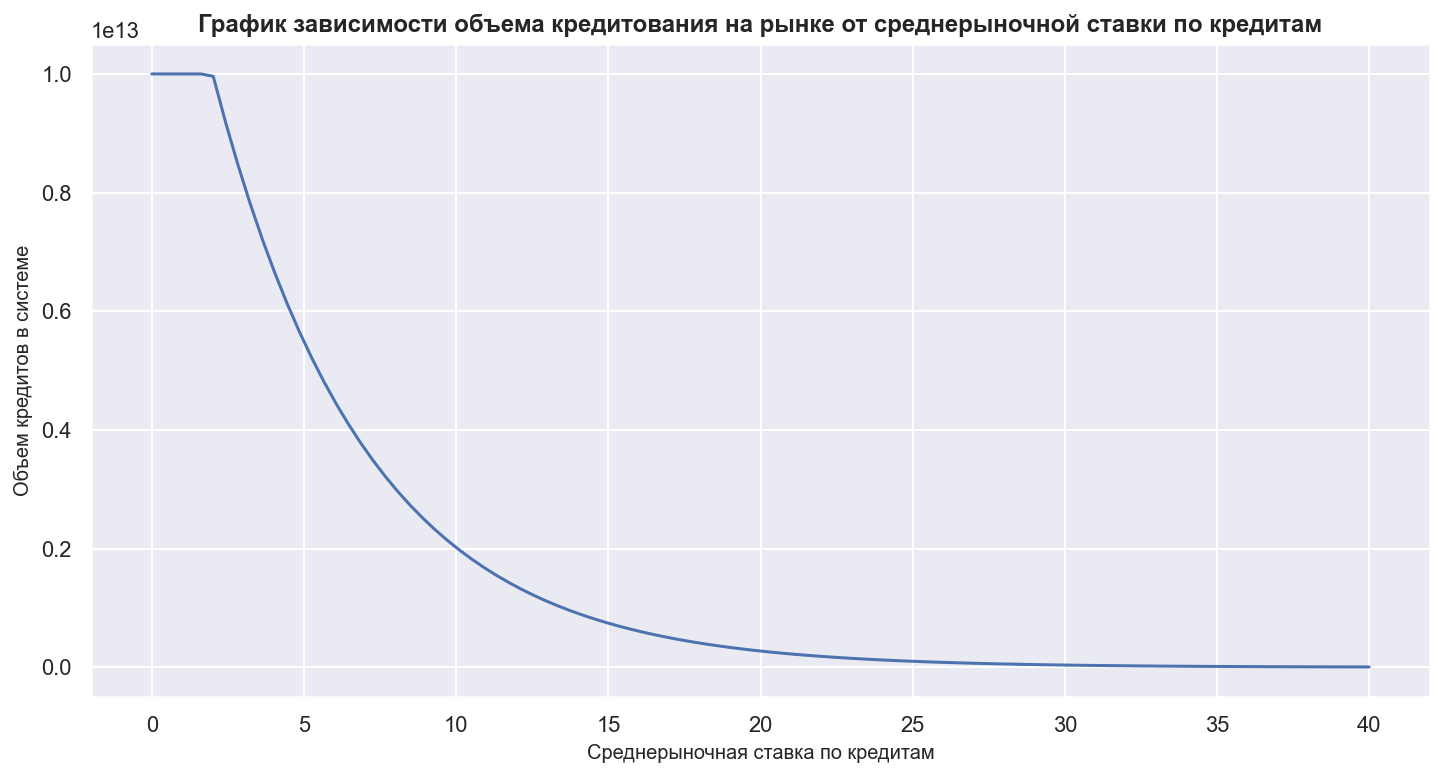

In [34]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(12, 6))
plt.xlabel('Среднерыночная ставка по кредитам', fontsize=10)
plt.ylabel('Объем кредитов в системе', fontsize=10)
plt.title('График зависимости объема кредитования на рынке от среднерыночной ставки по кредитам', fontsize=12, weight='bold')
plt.plot(x_arr, y_arr)
plt.show()

### Создадим класс для агентов нашей модели

In [ ]:
class BankSysAgent(Agent):
    def __init__(self, unique_id, model, agent_type, name):
        super().__init__(unique_id, model)
        self.agent_type = agent_type # тип агента (ЦБ/банк/частный сектор(ЧС))
        self.name = name # имя (название) агента
    
    def step(self):
        if self.agent_type == 'CB': # шаг для ЦБ (первый раунд)
            # if self.model.step_num > 0: # счетчик шагов?
            self.model.key_rate_t += self.model.k            
                                     * (self.model.rate_quart_to_year(
                                         self.model.delt_market_cred_portfolio)
                                        - self.model.target_inflat) # вычисление ключевой ставки
        elif self.agent_type == 'Bank': # шаг для банков (второй раунд)
            pass        
        else: # elif self.agent_type == 'PrivSect':
            # if self.model.step_num > 0: # с
            credit_rate_sum, deposit_rate_sum = 0, 0
            for a in self.model.schedule.agents:
                # if a.agent_type == 'Bank':
                rate_sum += self.model.credit_rate_dict.get(a.name, 0) # a.rate     
                deposit_rate_sum += self.model.deposit_rate_dict.get(a.name, 0)
            mean_bank_credit_rate = rate_sum / self.model.num_banks # считаем среднерыночную ставку
                                                                    # и объем взятых ЧС кредитов
            self.model.credit_vol = self.model.credit_vol_calc(mean_bank_credit_rate,
                                                               self.model.pelast, self.model.start_balance)
            self.model.deposit_vol = self.model.credit_vol # полагаем объем депозитов = объему кредитов
            for a in self.model.schedule.agents:
                if a.agent_type == 'Bank':
                    bank_credit_rate_spread = self.model.credit_rate_dict[a.name]
                                              - (rate_sum - self.model.credit_rate_dict[a.name]) 
                                              / (self.model.num_banks - 1)
                    self.model.cred_portfolio_dict[a.name] = -2 * self.model.sigm(self.model.alpha_dict[a.name] 
                                                                                  * bank_credit_rate_spread)
                                                              * self.model.credit_vol 
                                                              * (self.model.cred_portfolio_t_1_dict[a.name]
                                                                 / self.model.credit_vol_t_1)
                                         
                    bank_deposit_rate_spread = self.model.deposit_rate_dict[a.name]
                                               - (deposit_rate_sum - self.model.deposit_rate_dict[a.name]) 
                                               / (self.model.num_banks - 1)
                    self.model.deposit_portfolio_dict[a.name] = 2 * self.model.sigm(self.model.alpha_dict[a.name] 
                                                                                    * bank_deposit_rate_spread)
                                                                * self.model.deposit_vol
                                                                * (self.model.deposit_portfolio_t_1_dict[a.name]                                                                   
                                                                   / self.model.deposit_vol_t_1)
                                            
                    self.CBMoney = self.model.deposit_portfolio_dict[a.name] 
                                   - self.model.cred_portfolio_dict[a.name]
            
        raise NotImplementedError       

### Также создадим класс собственно для самой модели

In [ ]:
class BankSysModel(Model):
    def __init__(self, key_rate_t_1, delt_market_cred_portfolio, alpha_dict, 
                 cred_portfolio_t_1_dict, credit_vol_t_1, deposit_portfolio_t_1_dict,
                 deposit_vol_t_1, start_balance, default_rate=0.01, pelast=0.2, 
                 k=0.3, N=12, target_inflat=4):
        self.num_agents = N # общее число агентов
        self.num_banks = N - 2 # число банков (=общее число агентов - ЦБ - ЧС)
        self.key_rate_t_1 = key_rate_t_1 # предыдущая ключевая ставка (в %)<=обновл. в конце 2 раунда(key_rate_t_1 = key_rate_t)
        self.key_rate_t = key_rate_t_1 # текущая ключевая ставка (в %)
        self.k = k # коэффициент (для спреда) из формулы ключевой ставки 
        self.target_inflat = target_inflat # таргетная инфляция (в %)
        self.delt_market_cred_portfolio = delt_market_cred_portfolio # прирост портфеля за прошлый период
        self.default_rate = default_rate # доля дефолтных кредитов 
        self.pelast = pelast # эластичность частного сектора
        self.start_balance = start_balance # стартовый баланс системы
        
        self.alpha_dict # словарь для альфа (коэффициентов надежности)
        self.credit_rate_dict #\/ словарь для кредитных ставок (получаем значения во 2м раунде после оптимизации?)
        self.cred_portfolio_t_1_dict #\/ словарь для объемов портфелей на t-1 
                                    # <=обновл. в конце 2 раунда(cred_portfolio_t_1_dict = cred_portfolio_dict)
                                    # нужен для СredPortfolio_(t-2) в BankProfit
        self.cred_portfolio_dict # \/ словарь для объемов портфелей на t
        self.credit_vol_t_1 # объем кредитов на t-1 <=обновл. в конце 2 раунда(credit_vol_t_1 = credit_vol) 
                            # (нужен, чтобы посчитать CreditPortfolio при варьировании ставки на 2 шаге)
        self.deposit_rate_dict # \/ словарь для депозитных ставок (получаем значения во 2м раунде после оптимизации?)
        self.deposit_portfolio_t_1_dict #\/ словарь для объемов депозитных портфелей на t-1 
                                    # <=обновл. в конце 2 раунда(deposit_portfolio_t_1_dict = deposit_portfolio_dict)
                                    # нужен для DepositPortfolio_(t-2) в BankProfit
        self.deposit_portfolio_dict # \/ словарь для объемов депозитных портфелей на t
        self.deposit_vol_t_1 # объем депозитов на t-1 <=обновл. в конце 2 раунда(deposit_vol_t_1 = deposit_vol) 
                            # (нужен, чтобы посчитать DepositPortfolio при варьировании ставки на 2 шаге)
        
        self.schedule = BaseScheduler(self) # добавим шедулер
        
        
        # -----
        self.pairwise = pairwise # режим взаимодействия
        if self.pairwise == False:
            self.mu /= (self.num_agents - 1)
        
        self.schedule = RandomActivation(self) # добавим шедулер
        x_rand_gen = np.random.uniform(-1, 1, self.num_agents) # нагенерим рандомные x для инициализации агентов
        p_pos_div_p_neg = (1 + self.delta) / (1 - self.delta) # отношение p+/p-, полученное при раскрытии модуля
                                                              # в предположении, что положительных всегда не меньше
        N_neg_extr = int((self.num_agents * self.p_e) / (1 + p_pos_div_p_neg)) # число отриц. экстр.
        N_pos_extr = int(self.num_agents * self.p_e) - N_neg_extr # число полож. экстрем.
                        # формулы вывел на бумаге, еще пользуюсь соображением, что их сумма есть общее число экстрем. 
            
        idxs_neg_extr = np.argpartition(x_rand_gen, N_neg_extr)[:N_neg_extr] # объявляем в качестве экстрем. хвосты слева и справа
        idxs_pos_extr = np.argpartition(x_rand_gen, -N_pos_extr)[-N_pos_extr:] # используя их числа, вычисленные ранее, 
                                                                               # находим индексы экстремистов в массиве мнений x
        if self.pairwise: 
            self.made_step = [] # массив, куда будем закидывать тех, 
                                # кто поучаствовал на шаге в парном взаимодействии
        else:
            self.xs = [0 for _ in range(self.num_agents)] # списки для пересчитанных значений
            self.us = [0 for _ in range(self.num_agents)]
        # Инициализируем агентов и закидываем в шедулер
        for i, x in enumerate(x_rand_gen):
            if (i not in idxs_neg_extr) and (i not in idxs_pos_extr):  
                a = CustomAgent(i, self, x, self.u)
                self.schedule.add(a)
            else:
                a = CustomAgent(i, self, x, self.u_e, True)
                self.schedule.add(a)
                
        self.datacollector = DataCollector(
            agent_reporters={"Opinions": "x"}) # для сбора данных по прогону модели
                
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        if self.pairwise:
            self.made_step = []
        else:
            for a in self.schedule.agents:
                a.x = self.xs[a.unique_id]
                a.u = self.us[a.unique_id]
            self.xs = [0 for _ in range(self.num_agents)]
            self.us = [0 for _ in range(self.num_agents)]
    
    @staticmethod
    def rate_quart_to_year(rate):
        return ((1 + rate / 100) ** 4 - 1) * 100
    
    @staticmethod
    def rate_year_to_quart(rate):
        return ((1 + rate / 100) ** .25 - 1) * 100
    
    @staticmethod
    def credit_vol_calc(x, elast, start_balance):
        c = (10 * start_balance) * (mt.e ** (2 * elast))
        return c * mt.exp(-elast * x) if x >=2 else 10 * start_balance
    
    @staticmethod
    def sigm(x):
        return 1 / (1 + mt.exp(-x))

### Подготовим стартовые параметры для инициализации модели

In [21]:
key_rate_t_1 = 8.5 # ключевая ставка, объявленная в 
                   # декабре 2021 (конец прошлого квартала)
delt_market_cred_portfolio = round((df_cred_portf.iloc[:, 1].sum()
                                    - df_cred_portf.iloc[:, 0].sum())
                                    / df_cred_portf.iloc[:, 0].sum() * 100, 2)
start_balance = df_cred_portf.iloc[:, 1].sum() # стартовый баланс как 
                                               # сумма кредитных портфелей (в конце прошлого квартала декабря 2021)
alpha_dict = dict(zip(banks_of_interest_lst, np.linspace(0.8, 0.6, 10)))

4.69

### Произведем запуск модели 

In [ ]:
model = BankSysModel(key_rate, delt_market_cred_portfolio, pelast,
                     k=0.3, N=12, target_inflat=4)
for i in range(40):
    model.step()

In [ ]:
# opinion_data = model.datacollector.get_agent_vars_dataframe()
# opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))
# plt.show()